## Importing necessary libraries

In [1]:
import torch
from torchvision import datasets, transforms
from einops import rearrange
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
#import open3d as o3d
import numpy as np
import pandas as pd
#import seaborn as sns
import random
import glob
import cv2
import os

#from image import DepthImage

## Read file Helper Method

In [2]:
def read_coordinates(filename):
    # Read pairs of coordinates from the file
    coordinates = np.loadtxt(filename, dtype=np.float32, ndmin=2)
    
    # If needed, reshape the array to have two columns (x, y)
    if coordinates.shape[1] > 2:
        coordinates = coordinates.reshape((-1, 2))
    
    # Convert coordinates to rectangles (x1, y1, x2, y2)
    rectangles = []
    for i in range(0, len(coordinates), 2):
        x1, y1 = int(coordinates[i][0]), int(coordinates[i][1])
        x2, y2 = int(coordinates[i + 1][0]), int(coordinates[i + 1][1])
        
        # Ensure x1, y1 is the top-left corner and x2, y2 is the bottom-right corner
        if x1 > x2:
            x1, x2 = x2, x1
        if y1 > y2:
            y1, y2 = y2, y1
            
        rectangles.append((x1, y1, x2, y2))
        # print((x1, coordinates[i][0], y1, coordinates[i][1], x2, coordinates[i+1][0], y2, coordinates[i+1][1]))
    
    return rectangles

## Task1: Overlay Grasping Rectangles

In [3]:
def overlay_rectangles(image, positive_rectangles, negative_rectangles):
    image_copy = image.copy()

    for rect in positive_rectangles:
        cv2.rectangle(image_copy, (rect[0], rect[1]), (rect[2], rect[3]), (0, 255, 0), 2)  # Positive: Green
    for rect in negative_rectangles:
        cv2.rectangle(image_copy, (rect[0], rect[1]), (rect[2], rect[3]), (0, 0, 255), 2)  # Negative: Red
    return image_copy

## Task2: Augment image wit depth channel from pcd files

In [4]:
def generate_depth_image(pcd_file):
    di = DepthImage.from_pcd(pcd_file, (480, 640))
    
    di.inpaint()

    # of_name = pcd.replace('.txt', 'd.tiff')
    # print(of_name)
    return di.img.astype(np.float32)

In [4]:
def generate_depth_image2(FileName,shape):
    #code copied from https://github.com/skumra/robotic-grasping/blob/master/utils/dataset_processing/image.py
    img = np.zeros(shape)
    with open(FileName) as f:
        for l in f.readlines():
            ls = l.split()

            if len(ls) != 5:
                # Not a point line in the file.
                continue
            try:
                # Not a number, carry on.
                float(ls[0])
            except ValueError:
                continue

            i = int(ls[4])
            r = i // shape[1]
            c = i % shape[1]

            x = float(ls[0])
            y = float(ls[1])
            z = float(ls[2])
            
            #calculate distance to each point (l2 norm) in point cloud, divide by 1000 to get to m
            img[r, c] = np.sqrt(x ** 2 + y ** 2 + z ** 2)/1000


    """
    Inpaint missing values in depth image.
    :param missing_value: Value to fill in teh depth image.
    """
    # cv2 inpainting doesn't handle the border properly
    # https://stackoverflow.com/questions/25974033/inpainting-depth-map-still-a-black-image-border
    img = cv2.copyMakeBorder(img, 1, 1, 1, 1, cv2.BORDER_DEFAULT)
    mask = (img == 0).astype(np.uint8)

    # Scale to keep as float, but has to be in bounds -1:1 to keep opencv happy.
    scale = np.abs(img).max()
    img = img.astype(np.float32) / scale  # Has to be float32, 64 not supported.
    img = cv2.inpaint(img, mask, 1, cv2.INPAINT_NS)

    # Back to original size and value range.
    img = img[1:-1, 1:-1]
    img = img * scale
    
    return img


## Task3: Extract sub-patches and convert to yuv. Seperate color channel and depth channel

In [5]:
def extract_features(rgbd_image, positive_rectangles):
    features = []
    rgbd_image_copy = rgbd_image.copy()
    for rect in positive_rectangles:
        sub_patch = rgbd_image_copy[rect[1]:rect[3], rect[0]:rect[2]]
        # print(rgbd_image.shape)
        # print(sub_patch.shape)
        # print((rect[1]-rect[3], rect[0]-rect[2]))
        yuv_image = cv2.cvtColor(sub_patch[:, :, :3], cv2.COLOR_BGR2YUV)
        color_features = yuv_image[:, :, :3]
        depth_feature = sub_patch[:, :, 3]

        features.append([color_features, depth_feature])

    return features

In [24]:
def extract_features2(rgbd_image, positive_rectangles):
    features = []
    rgb_image_copy = rgbd_image[:,:,[0,1,2]]
    d_image_copy = rgbd_image[:,:,3]
    rgb_image_copy = rgb_image_copy.astype(np.uint8)
    for rect in positive_rectangles:
        sub_patch = rgb_image_copy[rect[1]:rect[3], rect[0]:rect[2]]
        sub_patch_depth = rgb_image_copy[rect[1]:rect[3], rect[0]:rect[2]]
        # print(rgbd_image.shape)
        # print(sub_patch.shape)
        # print((rect[1]-rect[3], rect[0]-rect[2]))
        yuv_image = cv2.cvtColor(sub_patch[:, :, :3], cv2.COLOR_BGR2YUV)
        color_features = yuv_image[:, :, :3]
        depth_feature = sub_patch_depth[:, :, 0]

        features.append([color_features, depth_feature])

    return features

## Task4: PCA whitening on depth feature

In [6]:
def apply_pca_whitening(depth_feature):
    original_shape = depth_feature.shape
    flattened_depth = depth_feature.flatten().reshape(-1, 1)

    pca = PCA(whiten=True)
    whitened_depth = pca.fit_transform(flattened_depth)

    # Reshape whitened_depth to the original shape
    whitened_depth = whitened_depth.reshape(original_shape)

    return whitened_depth

## Task 5: Visualize Point Cloud Data

In [7]:
def visualize_point_cloud(point_cloud_data):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(point_cloud_data[:, 0], point_cloud_data[:, 1], point_cloud_data[:, 2])
    plt.show()

## Parse dataset

Current Directory: /home/exouser/ME592_Spring2024/data_592/robotics_grasp/10


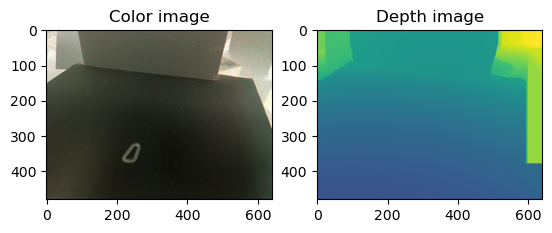

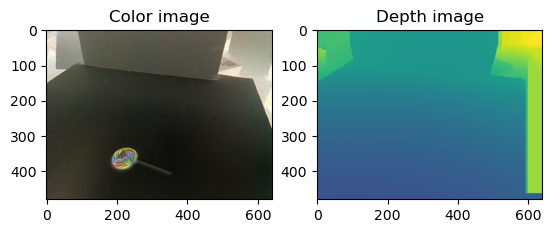

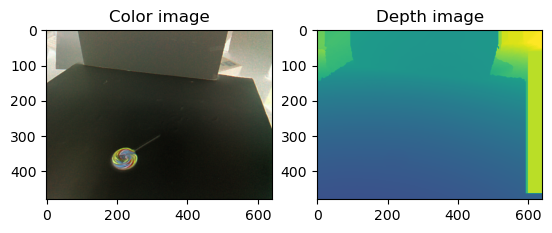

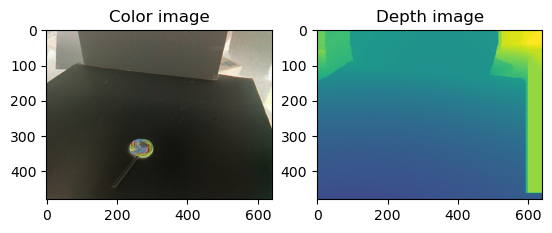

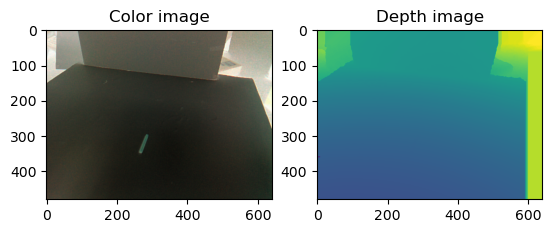

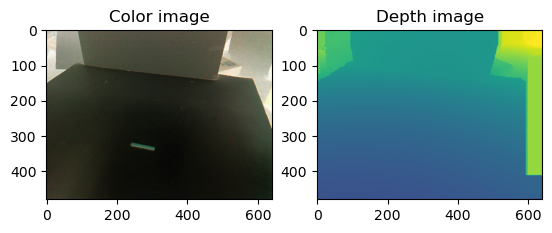

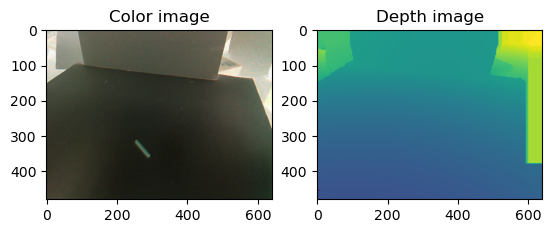

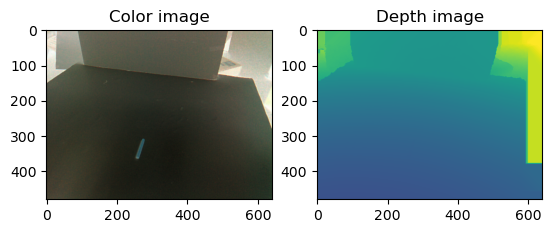

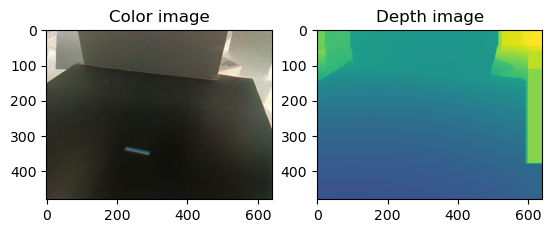

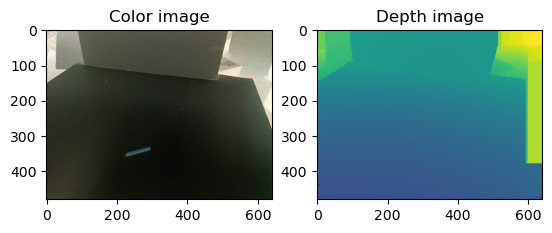

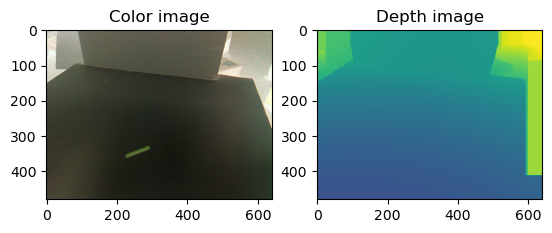

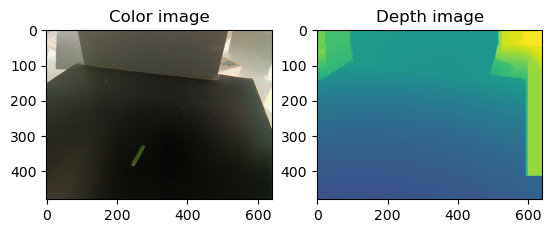

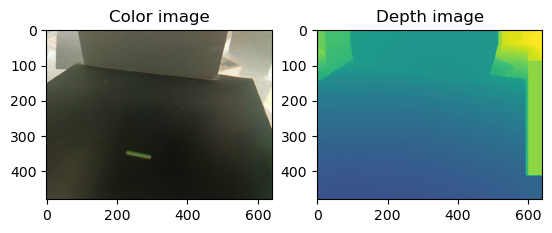

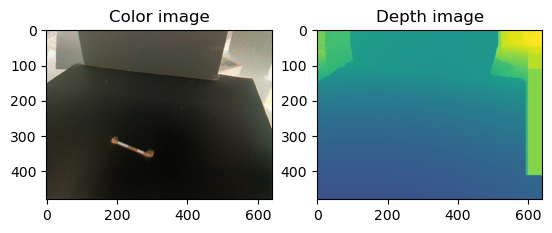

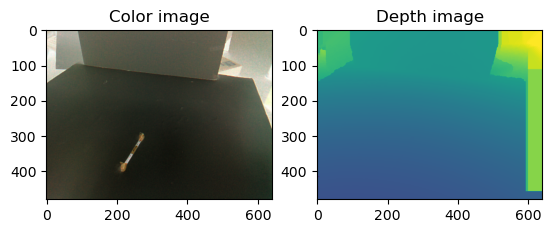

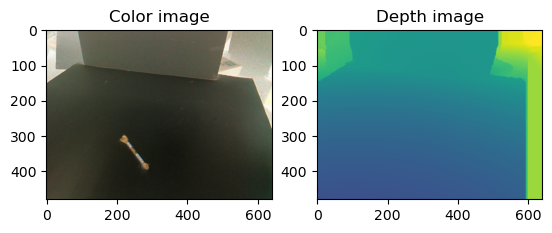

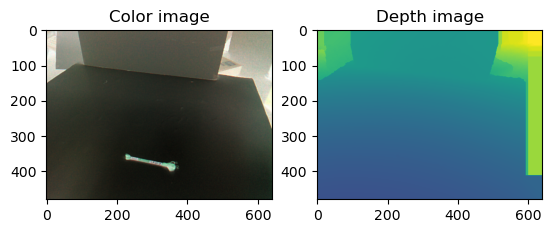

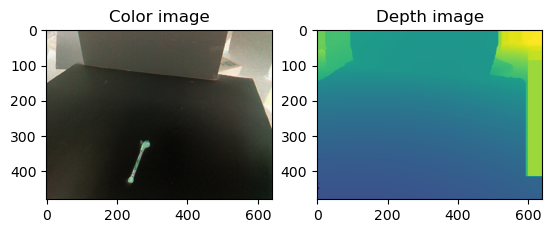

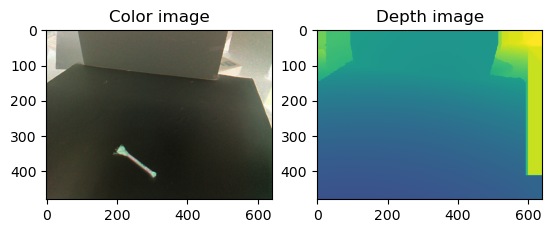

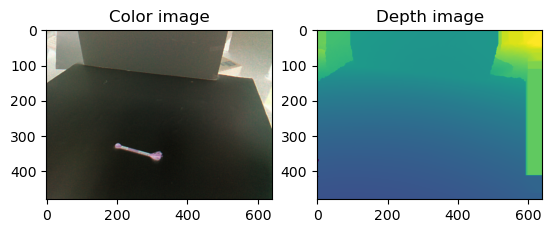

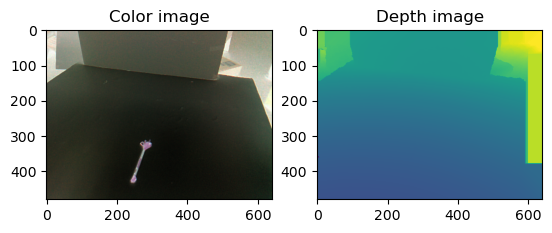

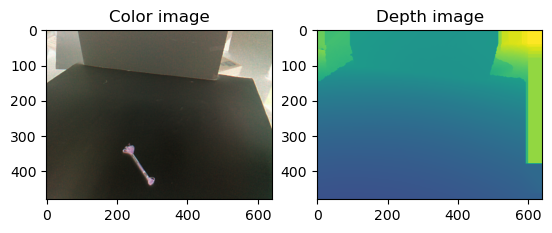

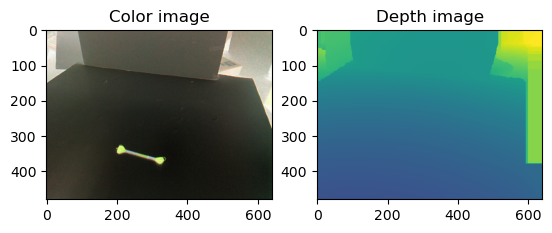

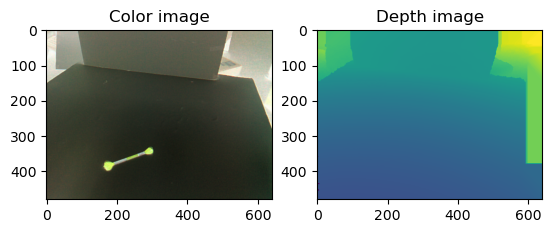

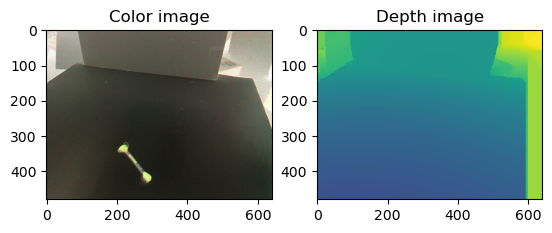

error: OpenCV(4.5.2) ../modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


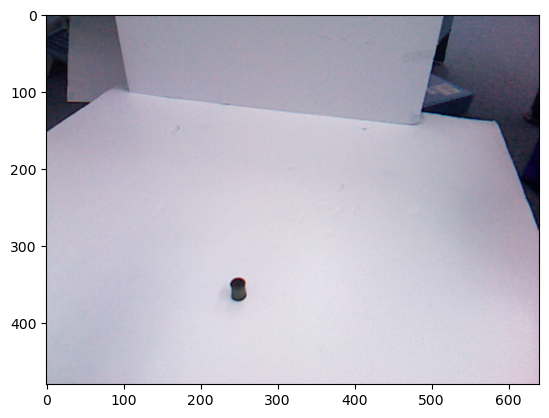

In [25]:
data_folder = os.path.join(os.path.dirname(os.getcwd()), "data_592", "robotics_grasp", "10")
print("Current Directory:", data_folder)

cneg_pattern = "*cneg.txt"
cpos_pattern = "*cpos.txt"
pcd_pattern = "pcd[0-9][0-9][0-9][0-9].txt"
png_pattern = "*.png"
tiff_pattern = "*.tiff"

cneg_files = sorted(glob.glob(os.path.join(data_folder, cneg_pattern)))
cpos_files = sorted(glob.glob(os.path.join(data_folder, cpos_pattern)))
pcd_files = sorted(glob.glob(os.path.join(data_folder, pcd_pattern)))
png_files = sorted(glob.glob(os.path.join(data_folder, png_pattern)))
tiff_files = sorted(glob.glob(os.path.join(data_folder, tiff_pattern)))

# Iterate over matching files and process them
for cneg_file, cpos_file, pcd_file, png_file, tiff_file in zip(cneg_files, cpos_files, pcd_files, png_files, tiff_files):
    # print(cneg_file)
    # print(cpos_file)
    # print(png_file)
    positive_rectangles = read_coordinates(cpos_file)
    negative_rectangles = read_coordinates(cneg_file)
    png_image = cv2.imread(png_file)
    # tiff_image = imageio.imread(tiff_file)
    overlayed_png_image = overlay_rectangles(png_image, positive_rectangles, negative_rectangles)
    plt.imshow(png_image)
    
    
    # cv2.imshow("Overlay on PNG", png_image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    shape = [len(png_image[:,0]),len(png_image[0,:])]
    depth_image = generate_depth_image2(pcd_file,shape)
    rgbd_image = np.zeros([len(png_image[:,0]),len(png_image[0,:]),4])
    rgbd_image[:,:,[0,1,2]] = png_image
    rgbd_image[:,:,3] = depth_image
    #rgbd_image = np.concatenate([png_image, depth_image], axis=2)
    
    features = extract_features2(rgbd_image, positive_rectangles)
    for feature in features:
        feature[1] = apply_pca_whitening(feature[1])
    
    plt.subplot(1, 2, 1)
    plt.title('Color image')
    plt.imshow((rgbd_image[:,:,:3]* 255).astype(np.uint8))
    plt.subplot(1, 2, 2)
    plt.title('Depth image')
    plt.imshow(rgbd_image[:,:,3:])
    plt.show()
    
#     break